In [1]:

## Important Libarries
import torch 
import torch.nn as nn
import torchvision 
from torchvision import datasets,transforms 
from torchvision.transforms import ToTensor 
import matplotlib.pyplot as plt 

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
## Dataset

from torchvision import datasets 
train_data = datasets.FashionMNIST(
    root = "/mnt/hdd/Datasets/Torchvision_Datasets/FashionMNIST/Train",
    train= True, 
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

test_data = datasets.FashionMNIST(
    root = "/mnt/hdd/Datasets/Torchvision_Datasets/FashionMNIST/Test",
    train= False, 
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)

In [3]:
image , label = train_data[0]
print(image.shape)
train_data

torch.Size([1, 28, 28])


Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: /mnt/hdd/Datasets/Torchvision_Datasets/FashionMNIST/Train
    Split: Train
    StandardTransform
Transform: ToTensor()

In [4]:
class_names = train_data.classes
class_names 

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

(-0.5, 27.5, 27.5, -0.5)

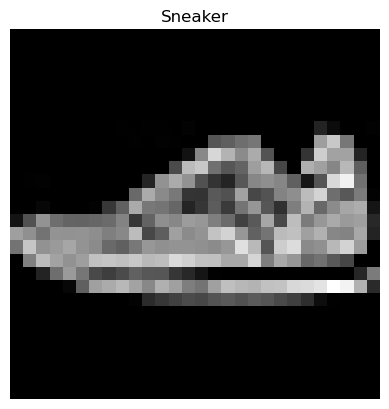

In [5]:
### Checking random samples from our data
import random
idx = random.randint(0, 59999)
image, label = train_data[idx]
#print(f"Imapge shape => {image.shape}")
plt.imshow(image.squeeze() , cmap="grey")
plt.title(class_names[label])
plt.axis(False)

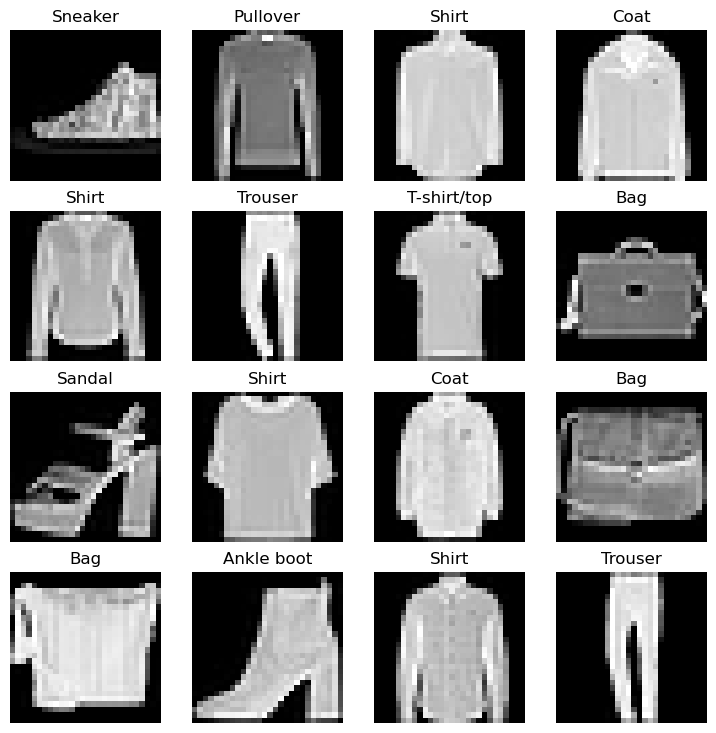

In [6]:
fig = plt.figure(figsize=(9,9))
rows,cols = 4,4

for i in range(1,rows*cols+1):
    random_idx = torch.randint(0,len(train_data),size=[1]).item()
    img,label = train_data[random_idx]
    fig.add_subplot(rows,cols,i)
    plt.imshow(img.squeeze(),cmap="gray")
    plt.title(class_names[label])
    plt.axis(False)

In [7]:
## Preaparing dataloader
from torch.utils.data import DataLoader

BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f" Length of train dataloader is {len(train_dataloader)} and batches of {train_dataloader.batch_size} so .... total samples {len(train_dataloader)*train_dataloader.batch_size}")
print(f" Length of test dataloader is {len(test_dataloader)} and batches of {test_dataloader.batch_size} so .... total samples {len(test_dataloader)*test_dataloader.batch_size}")

 Length of train dataloader is 1875 and batches of 32 so .... total samples 60000
 Length of test dataloader is 313 and batches of 32 so .... total samples 10016


In [8]:
## Checking dataloaders

train_features_batch , train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape , train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

(-0.5, 27.5, 27.5, -0.5)

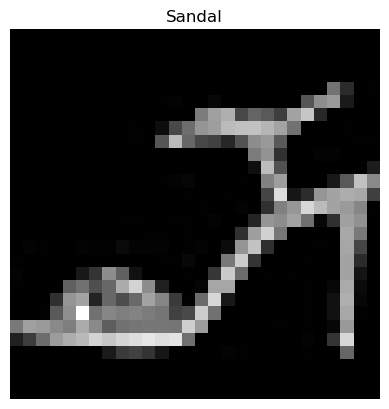

In [9]:
# Checking a sample from a dataloader

import torch
random_idx = torch.randint(0,len(train_features_batch),size=[1]).item()
img,label = train_features_batch[random_idx] , train_labels_batch[random_idx]
plt.imshow(img.squeeze(),cmap="gray")
plt.title(class_names[label])
plt.axis(False)

In [10]:

class FashionMNIST(nn.Module):
    
    def __init__(self,input_size:int,hidden_units:int,output_shape:int):
        
        super().__init__()
        self.layer_stack = nn. Sequential(
            nn.Flatten(),
            nn.Linear(input_size,hidden_units),
            nn.ReLU(),
            nn.Linear(hidden_units,output_shape),
            
        )
        
        
    def forward(self,x):
        return self.layer_stack(x)
        
        


model = FashionMNIST(28*28 , 256 , len(class_names))



In [11]:
x = torch.rand(1,28,28)
print(model(x))

tensor([[ 0.1254,  0.0438, -0.0228, -0.0445,  0.0988, -0.2035, -0.0769,  0.0273,
         -0.0732, -0.1052]], grad_fn=<AddmmBackward0>)


In [12]:
### Helper functions

import requests
from pathlib import Path 

if Path("helper_functions.py").is_file():
    print("Helper Functions exists")
else:
    print("Downloading helper functions")
    
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


Helper Functions exists


In [13]:
from helper_functions import accuracy_fn 


criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),lr=0.1)


In [14]:
### Some more helper functions for time calculations


from timeit import default_timer as timer 

def print_train_time(start:float, end:float , device:torch.device=None):
    total_time = end-start
    print(f"Train time on {device}:  {total_time:.3f} seconds ")

In [15]:



def eval_model(model_x:torch.nn.Module , data_loader: torch.utils.data.DataLoader , criterion:torch.nn.Module, accuracy_fn):
    
    
    loss, acc = 0 , 0
    model_x.eval()
    with torch.inference_mode():
        for X,y in data_loader:
            X = X.to(device)
            y = y.to(device)
            y_preds = model_x(X)
            
            
            loss += criterion(y_preds,y)
            acc += accuracy_fn(y,y_preds.argmax(dim=1))
            
        
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    
    return {"model_name": model_x.__class__.__name__ ,  "model_loss": loss.item() , "model_acc": acc}




    

In [16]:
def evaluate_model(model,data_loader,criterion,accuracy_fn):
    model.eval()
    test_loss , test_acc = 0.0 , 0.0
    with torch.inference_mode():
        
        for X_test,y_test in data_loader:
            X_test , y_test = X_test.to(device) , y_test.to(device)
            test_pred = model(X_test)
            test_loss += criterion(test_pred,y_test)
            test_acc += accuracy_fn(y_test,test_pred.argmax(dim=1))
            
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
    
    return test_loss,test_acc

In [17]:


def train_model(model,epochs,train_dataloader,test_dataloader,criterion,optimizer):
    from tqdm.auto import tqdm
    start_time = timer()
    for epoch in tqdm(range(epochs)):
        print(f" Training on Epoch: {epoch}\n --------")
        train_loss = 0.0 
        train_acc = 0.0
        for batch, (X,y) in enumerate(train_dataloader):
            
            
            model.train()
            X = X.to(device)
            y = y.to(device)
            y_pred = model(X)
            
            loss = criterion(y_pred,y)
            train_loss += loss
            train_acc += accuracy_fn(y,y_pred.argmax(dim=1))
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
            if batch%400==0:
                print(f" Looked at {batch*len(X)}/{len(train_dataloader.dataset)} samples")
            
        
        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        
        test_loss , test_acc = evaluate_model(model,test_dataloader,criterion,accuracy_fn)

        
        print(f"\n Training Loss: {train_loss:.3f} | Training Accuracy: {train_acc:.3f}  |  Test loss : {test_loss:.3f} | Test Accuracy: {test_acc:.3f}")
        
    end_time = timer()
    print_train_time(start_time,end_time,device=str(next(model.parameters()).device)    )
    

In [18]:
model = model.to(device)
train_model(model,5,train_dataloader,test_dataloader,criterion,optimizer)

/home/azwad/anaconda3/envs/Final/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  0%|          | 0/5 [00:00<?, ?it/s]

 Training on Epoch: 0
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 20%|██        | 1/5 [00:05<00:21,  5.30s/it]


 Training Loss: 0.554 | Training Accuracy: 80.368  |  Test loss : 0.442 | Test Accuracy: 84.515
 Training on Epoch: 1
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 40%|████      | 2/5 [00:10<00:15,  5.18s/it]


 Training Loss: 0.401 | Training Accuracy: 85.250  |  Test loss : 0.400 | Test Accuracy: 85.443
 Training on Epoch: 2
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:15<00:10,  5.13s/it]


 Training Loss: 0.362 | Training Accuracy: 86.777  |  Test loss : 0.386 | Test Accuracy: 86.012
 Training on Epoch: 3
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:20<00:05,  5.12s/it]


 Training Loss: 0.336 | Training Accuracy: 87.718  |  Test loss : 0.366 | Test Accuracy: 87.101
 Training on Epoch: 4
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


100%|██████████| 5/5 [00:25<00:00,  5.15s/it]


 Training Loss: 0.319 | Training Accuracy: 88.183  |  Test loss : 0.359 | Test Accuracy: 86.911
Train time on cuda:0:  25.772 seconds 


In [19]:
model_results = eval_model(model,test_dataloader,criterion,accuracy_fn)
print(model_results)

{'model_name': 'FashionMNIST', 'model_loss': 0.35870176553726196, 'model_acc': 86.91094249201278}


In [20]:
class FashionMNISTV2(nn.Module):
    
    def __init__(self,input_size,num_classes):
        
        super().__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2)
        )
        
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=7*7*512 , out_features=num_classes)
        )
        
    
    
    def forward(self,x):
        
        x = self.conv_block1(x)
        #print(f"Output shape of conv block 1  {x.shape}")
        x = self.conv_block2(x)
        #print(f"Output shape of conv block 2 {x.shape}")
        x = self.classifier(x)
        return x

In [21]:
model_1 = FashionMNISTV2(input_size=1,num_classes=len(class_names))
model_1 = model_1.to(device)
x = torch.rand(32,1,28,28).to(device)
print(model_1(x).shape)

torch.Size([32, 10])


In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.01)

train_model(model_1,5,train_dataloader,test_dataloader,criterion,optimizer)
model_1_results = eval_model(model_1,test_dataloader,criterion,accuracy_fn)
print(model_results)

  0%|          | 0/5 [00:00<?, ?it/s]

 Training on Epoch: 0
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 20%|██        | 1/5 [00:15<01:02, 15.50s/it]


 Training Loss: 1.127 | Training Accuracy: 83.832  |  Test loss : 0.415 | Test Accuracy: 88.758
 Training on Epoch: 1
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 40%|████      | 2/5 [00:30<00:46, 15.43s/it]


 Training Loss: 0.394 | Training Accuracy: 90.150  |  Test loss : 0.294 | Test Accuracy: 91.184
 Training on Epoch: 2
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:46<00:30, 15.43s/it]


 Training Loss: 0.288 | Training Accuracy: 91.825  |  Test loss : 0.275 | Test Accuracy: 91.304
 Training on Epoch: 3
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


 80%|████████  | 4/5 [01:01<00:15, 15.45s/it]


 Training Loss: 0.219 | Training Accuracy: 93.325  |  Test loss : 0.266 | Test Accuracy: 92.173
 Training on Epoch: 4
 --------
 Looked at 0/60000 samples
 Looked at 12800/60000 samples
 Looked at 25600/60000 samples
 Looked at 38400/60000 samples
 Looked at 51200/60000 samples


100%|██████████| 5/5 [01:17<00:00, 15.47s/it]


 Training Loss: 0.158 | Training Accuracy: 94.840  |  Test loss : 0.317 | Test Accuracy: 91.843
Train time on cuda:0:  77.372 seconds 


{'model_name': 'FashionMNIST', 'model_loss': 0.35870176553726196, 'model_acc': 86.91094249201278}


In [23]:
model_1_results = eval_model(model_1,test_dataloader,criterion,accuracy_fn)
print(model_1_results)

{'model_name': 'FashionMNISTV2', 'model_loss': 0.3167283535003662, 'model_acc': 91.84305111821087}


In [24]:
import pandas as pd

compare_results = pd.DataFrame([model_results,model_1_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNIST,0.358702,86.910942
1,FashionMNISTV2,0.316728,91.843051


In [25]:
## Making predictions


def make_predictions(model,  data , device):
    
    
    pred_probs = [ ]
    model.to(device)
    model.eval()
    with torch.inference_mode():
        for sample in data:
            
            sample = torch.unsqueeze(sample,dim=0).to(device)
            
            pred_logits = model(sample)
            
            pred_prob = torch.softmax(pred_logits.squeeze(),dim=0)
            
            pred_probs.append(pred_prob.cpu())
            
    return torch.stack(pred_probs)
    



In [26]:
test_data

Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: /mnt/hdd/Datasets/Torchvision_Datasets/FashionMNIST/Test
    Split: Test
    StandardTransform
Transform: ToTensor()

In [27]:
import random 



test_samples = []
test_labels= []

for sample,label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

test_samples[0].shape
    

torch.Size([1, 28, 28])

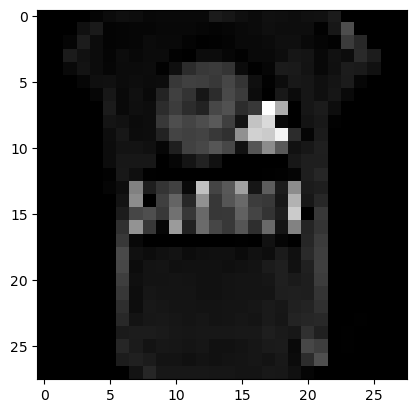

In [28]:
plt.imshow(test_samples[0].squeeze(),cmap="gray")

In [29]:


 
 
pred_probs = make_predictions(model_1,test_samples,device)

pred_classes = pred_probs.argmax(dim=1)
pred_classes , test_labels

(tensor([0, 1, 3, 1, 5, 1, 7, 0, 2]), [0, 1, 3, 1, 5, 1, 7, 0, 2])

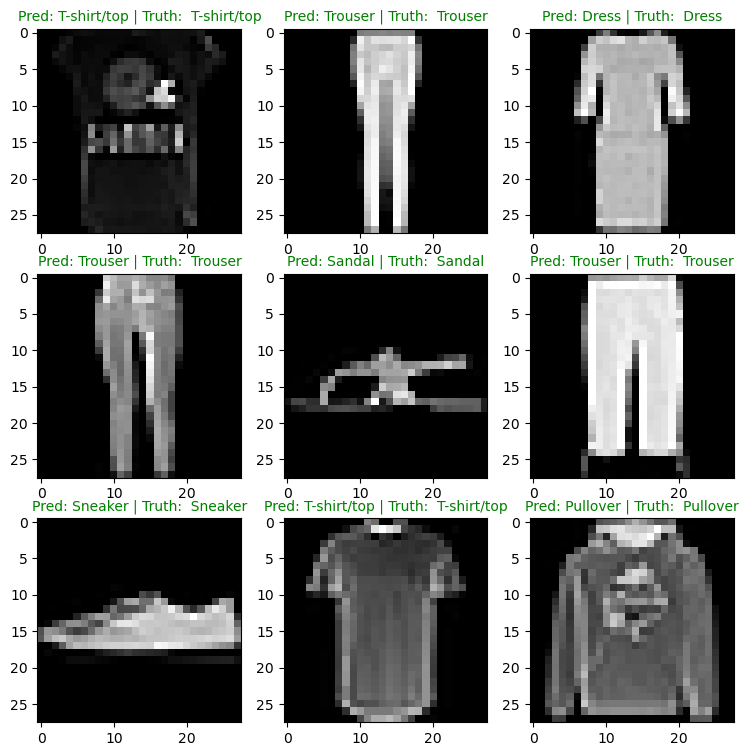

In [30]:
## Plot predictions

plt.figure(figsize=(9,9))
rows = 3
cols = 3

for i,sample in enumerate(test_samples):
    
    plt.subplot(rows,cols,i+1)
    
    plt.imshow(sample.squeeze() , cmap="gray")
    
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth:  {truth_label}"
    
    if pred_label == truth_label:
        plt.title(title_text,fontsize=10 , c = "g")
    else:
        plt.title(title_text,fontsize=10 , c = "r")
        
        
    

In [76]:



from tqdm.auto import tqdm
y_preds = [ ]
model_1.eval()
model_1.cpu()
with torch.inference_mode():
    
    for X,y in tqdm(test_dataloader, desc="Making predictions...."):
        
        X , y = X , y
        
        y_logit = model_1(X)
        y_pred = torch.softmax(y_logit.squeeze(),dim=0).argmax(dim=1)
        
        y_preds.append(y_pred.cpu())
    

y_pred_tensor = torch.cat(y_preds)
y_pred_tensor

Making predictions....: 100%|██████████| 313/313 [00:16<00:00, 19.07it/s]


tensor([9, 2, 3,  ..., 0, 0, 4])

In [32]:



try:
    import torchmetrics,mlxtend
    print(f"mlxtenmd version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1] >= 19, "mlxtend version should be 0.19.0 or higher")
except:
    !pip install -q torchmetrics -U mlxtend
    import torchmetrics,mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    

mlxtenmd version: 0.23.4
mlxtend version: 0.23.4


In [48]:
!pip install -q torchmetrics -U mlxtend


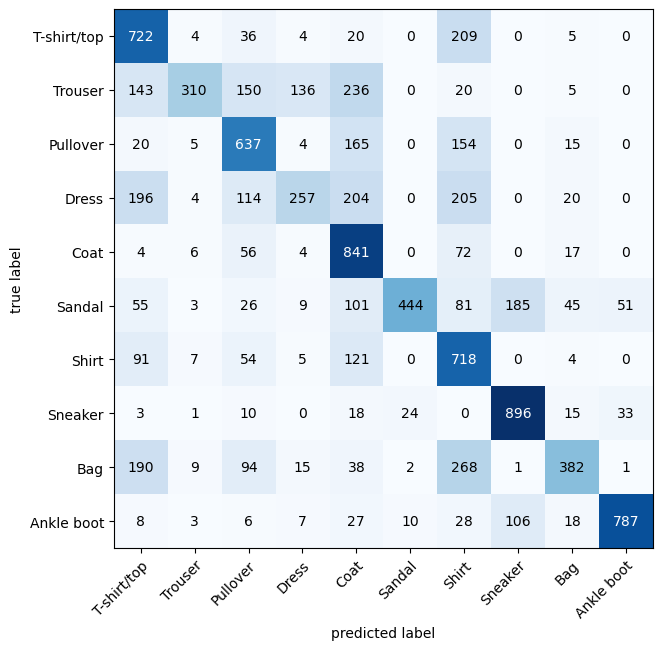

In [82]:
import mlxtend
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
import torch

confmat = ConfusionMatrix(num_classes=len(class_names),task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,target=test_data.targets)





fig , ax = plot_confusion_matrix(
    
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10,7)
)

In [ ]:
from pathlib import Path

MODEL_PATH =Path("models")
MODEL_PATH.mkdir(parents=True,exist_ok=True)

MODEL_NAME = " Simple CNN "
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME 

MODEL_SAVE_PATH
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model_1.state_dict(),f=MODEL_SAVE_PATH)


PosixPath('models/ Simple CNN ')

In [ ]:
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))